In [118]:
## ALL IMPORTS FOR A NEW NOTEBOOK
__SEED = 947
__N_FOLDS = 3
__NROWS = None

import os, sys, random, math
import matplotlib.pyplot as plt
# %matplotlib inline
plt.style.use('ggplot')

from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
pd.set_option('max_colwidth', 500)
pd.set_option('max_columns', 500)
pd.set_option('max_rows', 500)
import matplotlib.pylab as plt
import seaborn as sns
import itertools as it
import scipy
import glob
import matplotlib
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
from torch.optim import Optimizer
import torchvision.transforms.transforms as txf
import torch.optim.lr_scheduler as lr_scheduler
from collections import OrderedDict

from sklearn import metrics
from sklearn import preprocessing as pp
from sklearn import model_selection as ms
from sklearn import impute

import ml_utils as mutils
import time, datetime, pickle

font = {'size'   : 13}
matplotlib.rc('font', **font)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mutils.seed_everything(__SEED)

fold1 = ms.StratifiedKFold(n_splits=__N_FOLDS, shuffle=True, random_state=__SEED)
fold2 = ms.StratifiedKFold(n_splits=__N_FOLDS, shuffle=True, random_state=__SEED+3)
fold3 = ms.StratifiedKFold(n_splits=__N_FOLDS, shuffle=True, random_state=__SEED+5)

sys.stderr = open('/dev/stdout', 'w')

def load_pickled_object(path):
    with open(path, 'rb') as config_dictionary_file:
        return pickle.load(config_dictionary_file)
        
def pickle_save_object(dictionary, path):
    with open('config.dictionary', 'wb') as config_dictionary_file:
        pickle.dump(dictionary, config_dictionary_file)    

In [33]:
train = pd.read_csv("train.csv", index_col="id")
train.head()

,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,nom_5,nom_6,nom_7,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
id,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,F,N,Red,Trapezoid,Hamster,Russia,Bassoon,de4c57ee2,a64bc7ddf,598080a91,0256c7a4b,02e7c8990,3.0,Contributor,Hot,c,U,Pw,6.0,3.0,0
1,1.0,1.0,0.0,F,Y,Red,Star,Axolotl,NaN,Theremin,2bb3c3e5c,3a3a936e8,1dddb8473,52ead350c,f37df64af,3.0,Grandmaster,Warm,e,X,pE,7.0,7.0,0
2,0.0,1.0,0.0,F,N,Red,NaN,Hamster,Canada,Bassoon,b574c9841,708248125,5ddc9a726,745b909d1,NaN,3.0,NaN,Freezing,n,P,eN,5.0,9.0,0
3,NaN,0.0,0.0,F,N,Red,Circle,Hamster,Finland,Theremin,673bdf1f6,23edb8da3,3a33ef960,bdaa56dd1,f9d456e57,1.0,Novice,Lava Hot,a,C,NaN,3.0,3.0,0
4,0.0,NaN,0.0,T,N,Red,Triangle,Hamster,Costa Rica,NaN,777d1ac2c,3a7975e46,bc9cc2a94,NaN,c5361037c,3.0,Grandmaster,Cold,h,C,OZ,5.0,12.0,0


In [3]:
test = pd.read_csv("test.csv", index_col="id")
test.head()

,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,nom_5,nom_6,nom_7,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month
id,,,,,,,,,,,,,,,,,,,,,,,
600000,0.0,0.0,0.0,F,Y,Blue,Polygon,Axolotl,Finland,Piano,52f6dd16c,147d704e4,8d857a0a1,ca9ad1d4b,fced9e114,3.0,Novice,Boiling Hot,f,U,oU,3.0,9.0
600001,0.0,0.0,0.0,F,Y,Red,Circle,Lion,Russia,Bassoon,691ebeae8,8653dcc2e,67a8d4ebb,060a21580,7ca8775da,1.0,Novice,Cold,n,N,NaN,2.0,8.0
600002,0.0,0.0,0.0,F,Y,Blue,Circle,Axolotl,Russia,Theremin,81f792c16,6cdda499e,69403e18c,165e81a00,5940334c9,1.0,Expert,Warm,i,N,DN,2.0,6.0
600003,1.0,0.0,0.0,F,N,Red,Polygon,Axolotl,Costa Rica,Bassoon,c9134205b,acbca4827,cb681246b,77d41330d,6fbdeefc8,1.0,Expert,Hot,m,B,AG,1.0,6.0
600004,0.0,0.0,1.0,F,Y,Red,Circle,NaN,Finland,Theremin,f0f100f57,6f800b9af,cd9feb5c6,2218d9dfe,2a27c8fde,1.0,Contributor,Lava Hot,o,J,DT,3.0,3.0


In [4]:
mutils.summarize_all(train)

Dataset Shape: (600000, 24)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,bin_0,float64,17894,2,0,1,0,0.44
1,bin_1,float64,18003,2,0,1,1,0.69
2,bin_2,float64,17930,2,0,0,0,0.85
3,bin_3,object,18014,2,F,F,F,0.95
4,bin_4,object,18047,2,N,Y,N,1.00
5,nom_0,object,18252,3,Red,Red,Red,1.31
6,nom_1,object,18156,6,Trapezoid,Star,NaN,2.27
7,nom_2,object,18035,6,Hamster,Axolotl,Hamster,2.27
8,nom_3,object,18121,6,Russia,NaN,Canada,2.27
9,nom_4,object,18035,4,Bassoon,Theremin,Bassoon,1.52


In [5]:
stats, train_only, test_only = mutils.summarize_categorical(train, test, exclude_feat=["target"], target_for_cramerV="target")
stats

,Feature,Target Cramer's V,Unique values (Train),Unique values (Test),Train only value counts,Test only value counts,Missing (Train),Missing (Test),Value with the highest counts (Train),DataType
0,bin_0,0.060,2,2,0(0.0),0(0.0),17894(2.982),17894(2.982),0.0(88.063),float64
1,bin_1,0.018,2,2,0(0.0),0(0.0),18003(3.0),18003(3.0),0.0(79.003),float64
2,bin_2,0.066,2,2,0(0.0),0(0.0),17930(2.988),17930(2.988),0.0(69.974),float64
3,bin_3,0.001,2,2,0(0.0),0(0.0),18014(3.002),18014(3.002),F(61.035),object
4,bin_4,0.019,2,2,0(0.0),0(0.0),18047(3.008),18047(3.008),N(52.057),object
5,nom_0,0.016,3,3,0(0.0),0(0.0),18252(3.042),18252(3.042),Red(53.881),object
6,nom_1,0.071,6,6,0(0.0),0(0.0),18156(3.026),18156(3.026),Triangle(27.365),object
7,nom_2,0.046,6,6,0(0.0),0(0.0),18035(3.006),18035(3.006),Hamster(27.483),object
8,nom_3,0.060,6,6,0(0.0),0(0.0),18121(3.02),18121(3.02),India(27.478),object
9,nom_4,0.042,4,4,0(0.0),0(0.0),18035(3.006),18035(3.006),Theremin(51.437),object


<Figure size 432x288 with 0 Axes>

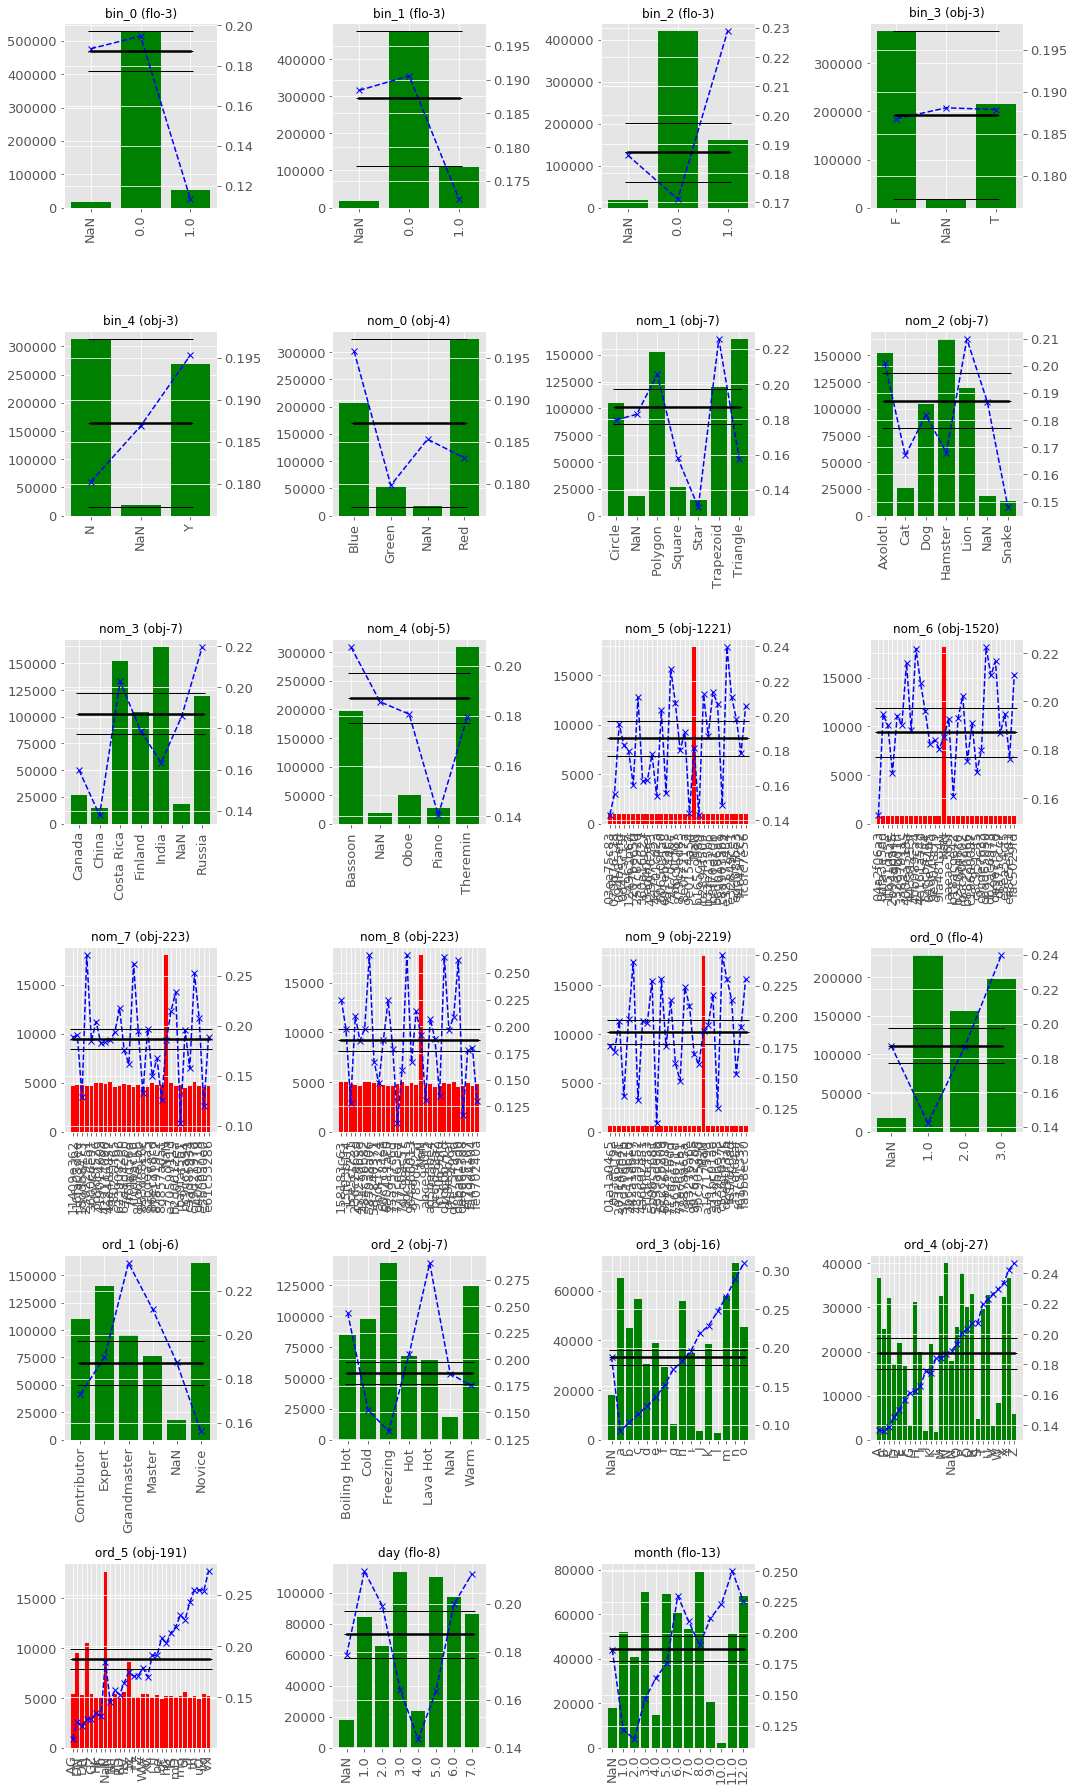

In [6]:
mutils.plot_multiple_categorical(train, [f for f in train.columns if f not in ["target"]], top_n=30, col_target="target")

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

lr_params = {
#     "solver":"lbfgs",
    "solver":"lbfgs",
    "penalty":"l2",
    "max_iter":2222,
    "verbose":1,
    "n_jobs":5,
#     "l1_ratio":0.05,
    "random_state":__SEED,
    "C":0.123456789
}

In [59]:
def cross_val_print(pipe, X, y, cv, scoring="roc_auc", best_score=0.):
    curt = time.time()
    scores = ms.cross_validate(pipe, X, y, cv=cv, scoring=scoring, return_train_score=True)
    cv_score = scores["test_score"].mean()
    train_score = scores["train_score"].mean()
    
    if cv == fold1:
        precision=1
    elif cv == fold2:
        precision=2
    elif cv == fold3:
        precision=3
        
    down = '\u2193'
    up = "\u2191"
    curarr = "\u30000"
    if (cv_score-best_score)>0:
        curarr = up
    elif (cv_score-best_score)<0:
        curarr = down
    
    print("{}CV{} valid score: {:.7f} - Previous valid score: {:.7f} - Train score: {:6f} - Time {}".format(curarr, precision, cv_score, best_score, train_score, str(datetime.timedelta(seconds=time.time()-curt))))
    
    if cv_score>best_score:
        best_score = cv_score
    
    return cv_score, best_score

In [54]:
from sklearn.base import BaseEstimator, TransformerMixin

class CustomLabelEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.le_={}
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        
        df = X.copy()
        for i, col in enumerate(self.columns):
            le = pp.LabelEncoder()
            self.le_[col] = le
            df[col] = le.fit_transform(df[col].astype(str))
        return df


class CustomMostFrequentImputer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.mode = None
    def fit(self, X, y=None):
        self.mode = X[self.columns].mode().values[0]
        return self
    def transform(self, X, y=None):
        df = X.copy()
        for i, col in enumerate(self.columns):
#             print(i)
            df[col].fillna(self.mode[i],inplace=True)
        return df

class CustomMedianImputer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.median = None
    def fit(self, X, y=None):
        self.median = X[self.columns].median().values
#         print(self.median)
        return self
    def transform(self, X, y=None):
        df = X.copy()
        for i, col in enumerate(self.columns):
#             print(i)
            df[col].fillna(self.median[i],inplace=True)
        return df

class CustomNewCategoryImputer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        df = X.copy()
        for i, col in enumerate(self.columns):
#             print(i)
            df[col].fillna(col+"_na_cat",inplace=True)
            df[col] = df[col].astype(str)
        return df

In [60]:
def fit_save(model, train, target, test, label):
    preds = model.fit(train, target).predict_proba(test[list(train.columns)])[:,1]
    pd.DataFrame({"id":test.index.values, "target":preds}).to_csv(label+"_submission.csv", index=False)

### Baseline 1: Logistic Regression, MostFrequentImputer and All One-Hot

In [19]:
%%time
all_train_cols = [col for col in train.columns if col not in ["target"]] 

# print(all_train_cols)

imputer = CustomMostFrequentImputer(all_train_cols)
ohe = (pp.OneHotEncoder(categories="auto",dtype="uint8",handle_unknown="ignore"), all_train_cols)

pipe = make_pipeline(imputer, make_column_transformer(ohe), LogisticRegression(**lr_params))

_, bl1cv1 = cross_val_print(pipe, train.drop(["target"], axis=1), train["target"], cv=fold1)
_, bl1cv2 = cross_val_print(pipe, train.drop(["target"], axis=1), train["target"], cv=fold2)
_, bl1cv3 = cross_val_print(pipe, train.drop(["target"], axis=1), train["target"], cv=fold3)

print("Average: {}".format((bl1cv1+bl1cv2+bl1cv3)/3.0))

↑CV1 valid score: 0.7846625 - Previous valid score: 0.0000000 - Train score: 0.797842 - Time 220.520085
↑CV2 valid score: 0.7844804 - Previous valid score: 0.0000000 - Train score: 0.797932 - Time 225.904794
↑CV3 valid score: 0.7847017 - Previous valid score: 0.0000000 - Train score: 0.797848 - Time 225.047026
Average: 0.7846148622940069
CPU times: user 5min 39s, sys: 24.3 s, total: 6min 3s
Wall time: 11min 11s


### Baseline 2: Logistic Regression, MedianImputer and All One-Hot

In [13]:
# %%time
# all_train_cols = [col for col in train.columns if col not in ["target"]] 

# # print(all_train_cols)
# le = CustomLabelEncoder(all_train_cols)
# imputer = CustomMedianImputer(all_train_cols)
# ohe = (pp.OneHotEncoder(categories="auto",dtype="uint8",handle_unknown="ignore"), all_train_cols)

# pipe = make_pipeline(le,imputer, make_column_transformer(ohe), LogisticRegression(**lr_params))

# _, bl2cv1 = cross_val_print(pipe, train.drop(["target"], axis=1), train["target"], cv=fold1)
# _, bl2cv2 = cross_val_print(pipe, train.drop(["target"], axis=1), train["target"], cv=fold2)
# _, bl2cv3 = cross_val_print(pipe, train.drop(["target"], axis=1), train["target"], cv=fold3)

# print("Average: {}".format((bl2cv1+bl2cv2+bl2cv3)/3.0))

↑  CV1 score on valid: 0.7694566 - Previous best valid score: 0.0000000 - Train mean score: 0.800715<br>
↑  CV2 score on valid: 0.7694375 - Previous best valid score: 0.0000000 - Train mean score: 0.800749<br>
↑  CV3 score on valid: 0.7700768 - Previous best valid score: 0.0000000 - Train mean score: 0.800703<br>
Average: 0.7696569914027639<br>
CPU times: user 16min 31s, sys: 1min 11s, total: 17min 42s<br>
Wall time: 12min 18s<br>

### Baseline 3: Logistic Regression, NA-Class and All One-Hot

In [11]:
%%time
all_train_cols = [col for col in train.columns if col not in ["target"]] 

# print(all_train_cols)
imputer = CustomNewCategoryImputer(all_train_cols)
ohe = (pp.OneHotEncoder(categories="auto",dtype="uint8",handle_unknown="ignore"), all_train_cols)

pipe = make_pipeline(imputer, make_column_transformer(ohe), LogisticRegression(**lr_params))

_, bl3cv1 = cross_val_print(pipe, train.drop(["target"], axis=1), train["target"], cv=fold1)
_, bl3cv2 = cross_val_print(pipe, train.drop(["target"], axis=1), train["target"], cv=fold2)
_, bl3cv3 = cross_val_print(pipe, train.drop(["target"], axis=1), train["target"], cv=fold3)

print("Average: {}".format((bl3cv1+bl3cv2+bl3cv3)/3.0))

↑  CV1 score on valid: 0.7876527 - Previous best valid score: 0.0000000 - Train mean score: 0.800715
↑  CV2 score on valid: 0.7874604 - Previous best valid score: 0.0000000 - Train mean score: 0.800751
↑  CV3 score on valid: 0.7877373 - Previous best valid score: 0.0000000 - Train mean score: 0.800707
Average: 0.7876168139368726
CPU times: user 6min 36s, sys: 26.3 s, total: 7min 3s
Wall time: 11min 44s


In [12]:
new_pipe = make_pipeline(imputer, make_column_transformer(ohe), LogisticRegression(**lr_params))
fit_save(new_pipe,  train.drop(["target"], axis=1), train["target"], test, "NA-Class_Imputing_OHE")

In [36]:
BASELINE = {
    "MFI1":bl1cv1,  # MFI == Most Frequent Imputation
    "MFI2":bl1cv2,
    "MFI3":bl1cv3,
    "NAI1":bl3cv1, # NAI == NA class Imputation
    "NAI2":bl3cv2,
    "NAI3":bl3cv3
}
# pickle_save_object(BASELINE, "BASELINES.pt")

### Binary Features Exploration

<Figure size 432x288 with 0 Axes>

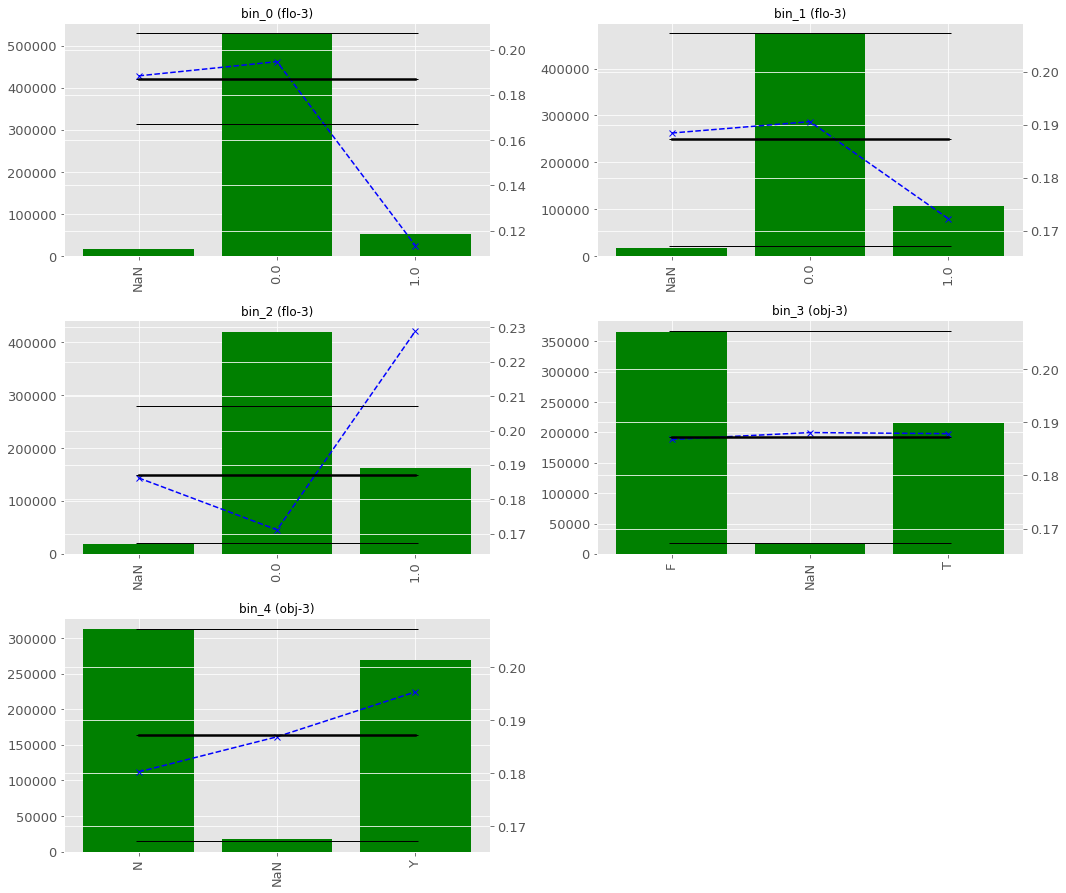

In [67]:
binary_features = ["bin_"+str(i) for i in range(5)]
mutils.plot_multiple_categorical(train, binary_features, col_target="target", n_subplots_per_row=2, landmark=0.02)

In [56]:
# drop bin_3 and check if score improves over the corresponding baselines

In [62]:
%%time
target_cols = ["target"]
drop_cols = ["bin_3"]

all_train_cols = [col for col in train.columns if col not in target_cols+drop_cols] 

# print(all_train_cols)

imputer = CustomMostFrequentImputer(all_train_cols)
ohe = (pp.OneHotEncoder(categories="auto",dtype="uint8",handle_unknown="ignore"), all_train_cols)

pipe = make_pipeline(imputer, make_column_transformer(ohe), LogisticRegression(**lr_params))

bl1sc1, bl1cv1 = cross_val_print(pipe, train.drop(target_cols+drop_cols, axis=1), train["target"], cv=fold1, best_score=BASELINE["MFI1"])
bl1sc2, bl1cv2 = cross_val_print(pipe, train.drop(target_cols+drop_cols, axis=1), train["target"], cv=fold2, best_score=BASELINE["MFI2"])
bl1sc3, bl1cv3 = cross_val_print(pipe, train.drop(target_cols+drop_cols, axis=1), train["target"], cv=fold3, best_score=BASELINE["MFI3"])

print("Average: {}".format((bl1sc1+bl1sc2+bl1sc3)/3.0))

↑CV1 valid score: 0.7846632 - Previous valid score: 0.7846625 - Train score: 0.797840 - Time 0:03:28.498686
↓CV2 valid score: 0.7844798 - Previous valid score: 0.7844804 - Train score: 0.797929 - Time 0:03:24.519407
↑CV3 valid score: 0.7847032 - Previous valid score: 0.7847017 - Train score: 0.797852 - Time 0:03:23.786057
Average: 0.7846156222035421
CPU times: user 5min 26s, sys: 24.4 s, total: 5min 51s
Wall time: 10min 17s


In [63]:
%%time
target_cols = ["target"]
drop_cols = ["bin_3"]
all_train_cols = [col for col in train.columns if col not in target_cols+drop_cols] 


# print(all_train_cols)
imputer = CustomNewCategoryImputer(all_train_cols)
ohe = (pp.OneHotEncoder(categories="auto",dtype="uint8",handle_unknown="ignore"), all_train_cols)

pipe = make_pipeline(imputer, make_column_transformer(ohe), LogisticRegression(**lr_params))

bl3sc1, bl3cv1 = cross_val_print(pipe, train.drop(target_cols+drop_cols, axis=1), train["target"], cv=fold1, best_score=BASELINE["NAI1"])
bl3sc2, bl3cv2 = cross_val_print(pipe, train.drop(target_cols+drop_cols, axis=1), train["target"], cv=fold2, best_score=BASELINE["NAI2"])
bl3sc3, bl3cv3 = cross_val_print(pipe, train.drop(target_cols+drop_cols, axis=1), train["target"], cv=fold3, best_score=BASELINE["NAI3"])

print("Average: {}".format((bl3sc1+bl3sc2+bl3sc3)/3.0))

↑CV1 valid score: 0.7876556 - Previous valid score: 0.7876527 - Train score: 0.800715 - Time 0:03:36.571259
↑CV2 valid score: 0.7874626 - Previous valid score: 0.7874604 - Train score: 0.800750 - Time 0:03:37.177814
↑CV3 valid score: 0.7877487 - Previous valid score: 0.7877373 - Train score: 0.800706 - Time 0:03:47.224403
Average: 0.7876222906649707
CPU times: user 6min 26s, sys: 25.7 s, total: 6min 52s
Wall time: 11min 1s


In [64]:
new_pipe = make_pipeline(imputer, make_column_transformer(ohe), LogisticRegression(**lr_params))
fit_save(new_pipe,  train.drop(target_cols+drop_cols, axis=1), train["target"], test.drop(drop_cols, axis=1), "bin_3_dropped_NA-Class_Imputing_OHE")

So, having bin_3 dropped is ok! Although it didn't improve my LB score, it didn't decrease it either, which is good, because the model will have lower complexity. So, we're going to have bin_3 dropped.

#### Binary Interactions

bin_3-bin_4 == not good
So, may be just drop bin_3....it's not working with anything apparently

In [75]:
%%time
# Interactions for bin_3 & bin_4
df = train.copy()

df["bin_3_bin_1"] = df["bin_3"].astype(str)+df["bin_1"].astype(str)
df["bin_1_bin_3"] = df["bin_1"].astype(str)+df["bin_3"].astype(str)

target_cols = ["target"]
drop_cols = ["bin_3", "bin_1"]
all_train_cols = [col for col in df.columns if col not in target_cols+drop_cols] 


# print(all_train_cols)
imputer = CustomNewCategoryImputer(all_train_cols)
ohe = (pp.OneHotEncoder(categories="auto",dtype="uint8",handle_unknown="ignore"), all_train_cols)

pipe = make_pipeline(imputer, make_column_transformer(ohe), LogisticRegression(**lr_params))

bl3sc1, bl3cv1 = cross_val_print(pipe, df.drop(target_cols+drop_cols, axis=1), df["target"], cv=fold1, best_score=BASELINE["NAI1"])
bl3sc2, bl3cv2 = cross_val_print(pipe, df.drop(target_cols+drop_cols, axis=1), df["target"], cv=fold2, best_score=BASELINE["NAI2"])
bl3sc3, bl3cv3 = cross_val_print(pipe, df.drop(target_cols+drop_cols, axis=1), df["target"], cv=fold3, best_score=BASELINE["NAI3"])

print("Average: {} Baseline Avg: {} DIFF WRT Base: {}".format((bl3sc1+bl3sc2+bl3sc3)/3.0, (BASELINE["NAI1"]+BASELINE["NAI2"]+BASELINE["NAI3"])/3,((bl3sc1+bl3sc2+bl3sc3)/3.0 - (BASELINE["NAI1"]+BASELINE["NAI2"]+BASELINE["NAI3"])/3)))

↓CV1 valid score: 0.7876477 - Previous valid score: 0.7876527 - Train score: 0.800726 - Time 0:03:55.958468
↓CV2 valid score: 0.7874578 - Previous valid score: 0.7874604 - Train score: 0.800759 - Time 0:03:59.111189
↓CV3 valid score: 0.7877249 - Previous valid score: 0.7877373 - Train score: 0.800716 - Time 0:04:02.446838
Average: 0.7876101338990716 Baseline Avg: 0.7876168139368726 DIFF WRT Base: -6.680037800910199e-06
CPU times: user 6min 20s, sys: 25.7 s, total: 6min 46s
Wall time: 11min 58s


### Ordinal Features Exploration

<Figure size 432x288 with 0 Axes>

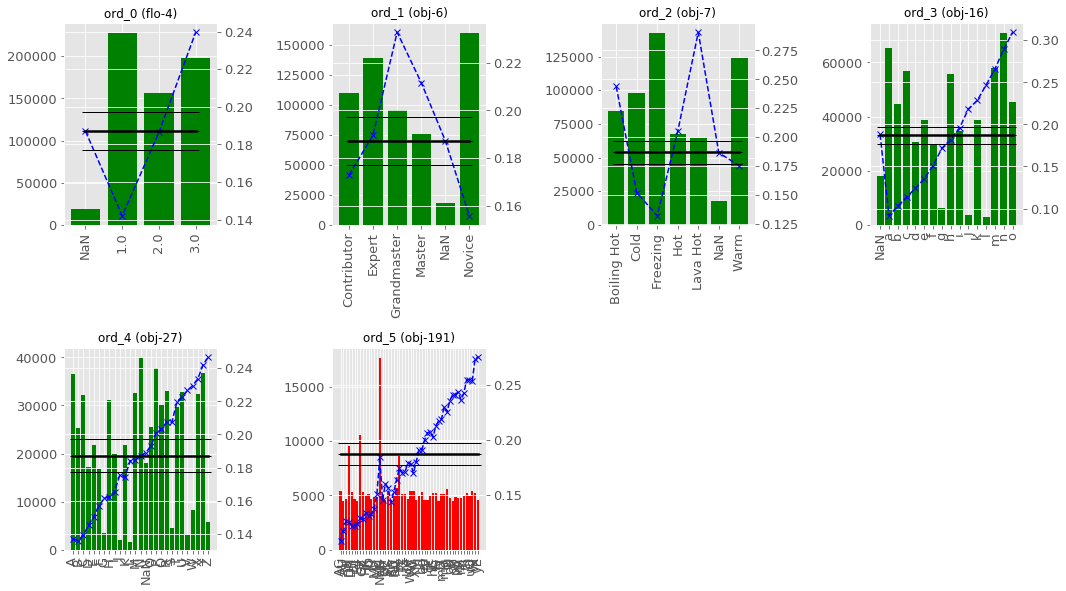

In [76]:
ordinal_features = ["ord_"+str(i) for i in range(6)]
mutils.plot_multiple_categorical(train, ordinal_features, col_target="target", top_n=50)

In [128]:
df = train.copy()
transform_dict = {}
for c in ordinal_features:
    srs = df.groupby(c)["target"].mean()
    transform_dict[c] = {k:i for i,k in enumerate(np.sort(srs.index.values))}

In [129]:
transform_dict

{'ord_0': {1.0: 0, 2.0: 1, 3.0: 2},
 'ord_1': {'Contributor': 0,
  'Expert': 1,
  'Grandmaster': 2,
  'Master': 3,
  'Novice': 4},
 'ord_2': {'Boiling Hot': 0,
  'Cold': 1,
  'Freezing': 2,
  'Hot': 3,
  'Lava Hot': 4,
  'Warm': 5},
 'ord_3': {'a': 0,
  'b': 1,
  'c': 2,
  'd': 3,
  'e': 4,
  'f': 5,
  'g': 6,
  'h': 7,
  'i': 8,
  'j': 9,
  'k': 10,
  'l': 11,
  'm': 12,
  'n': 13,
  'o': 14},
 'ord_4': {'A': 0,
  'B': 1,
  'C': 2,
  'D': 3,
  'E': 4,
  'F': 5,
  'G': 6,
  'H': 7,
  'I': 8,
  'J': 9,
  'K': 10,
  'L': 11,
  'M': 12,
  'N': 13,
  'O': 14,
  'P': 15,
  'Q': 16,
  'R': 17,
  'S': 18,
  'T': 19,
  'U': 20,
  'V': 21,
  'W': 22,
  'X': 23,
  'Y': 24,
  'Z': 25},
 'ord_5': {'AG': 0,
  'AI': 1,
  'AU': 2,
  'AW': 3,
  'Ay': 4,
  'BL': 5,
  'BX': 6,
  'Bx': 7,
  'CN': 8,
  'CU': 9,
  'Cn': 10,
  'DI': 11,
  'DN': 12,
  'DR': 13,
  'DT': 14,
  'Dj': 15,
  'Dn': 16,
  'EC': 17,
  'Ey': 18,
  'FB': 19,
  'FH': 20,
  'Fl': 21,
  'GZ': 22,
  'HF': 23,
  'HK': 24,
  'HO': 25,
  'Hk

In [133]:
normal_dict = {
    'ord_0': {1.0: 0, 2.0: 1, 3.0: 2, "N_A":3},
    "ord_1":{"Novice":0,"Contributor":1,"Expert":2, "Master":3, "Grandmaster":4,"N_A":5,},
    "ord_2":{"Freezing":0,"Cold":1,"Warm":2, "Hot":3, "Boiling Hot":4,"Lava Hot":5,"N_A":6},
    'ord_3': {'a': 0,'b': 1,'c': 2,'d': 3,'e': 4,'f': 5,'g': 6,'h': 7,'i': 8,'j': 9,'k': 10
              ,'l': 11,'m': 12,'n': 13,'o': 14, "N_A":15},
    'ord_4': {'A': 0,'B': 1,'C': 2,'D': 3,'E': 4,'F': 5,'G': 6,'H': 7,'I': 8,'K': 9,'J': 10,'L': 11,'M': 12,'N': 13,
              'O': 14,'P': 15,'Q': 16,'R': 17,'S': 18,'T': 19,'U': 20,'V': 21,'W': 22,'X': 23,'Y': 24,'Z': 25, "N_A":26},
     'ord_5': {'AG': 0,'AI': 1,'AU': 2,'AW': 3,'Ay': 4,'BL': 5,'BX': 6,'Bx': 7,'CN': 8,'CU': 9,'Cn': 10,'DI': 11,'DN': 12,
               'DR': 13,'DT': 14,'Dj': 15,'Dn': 16,
  'EC': 17,
  'Ey': 18,
  'FB': 19,
  'FH': 20,
  'Fl': 21,
  'GZ': 22,
  'HF': 23,
  'HK': 24,
  'HO': 25,
  'Hk': 26,
  'IA': 27,
  'IS': 28,
  'Ib': 29,
  'In': 30,
  'Io': 31,
  'Iq': 32,
  'JQ': 33,
  'JT': 34,
  'Ji': 35,
  'Kq': 36,
  'LS': 37,
  'LY': 38,
  'Lo': 39,
  'MF': 40,
  'MU': 41,
  'MV': 42,
  'MX': 43,
  'Mg': 44,
  'Mq': 45,
  'NS': 46,
  'NT': 47,
  'Nh': 48,
  'OM': 49,
  'OZ': 50,
  'Oe': 51,
  'Ox': 52,
  'PG': 53,
  'PS': 54,
  'Pk': 55,
  'Pw': 56,
  'QV': 57,
  'Qm': 58,
  'RB': 59,
  'RD': 60,
  'RT': 61,
  'RV': 62,
  'Re': 63,
  'Rj': 64,
  'Ro': 65,
  'Rv': 66,
  'Rz': 67,
  'SL': 68,
  'SS': 69,
  'Sk': 70,
  'Sz': 71,
  'TH': 72,
  'TL': 73,
  'TP': 74,
  'TZ': 75,
  'Tg': 76,
  'Ty': 77,
  'Tz': 78,
  'US': 79,
  'UV': 80,
  'WC': 81,
  'WW': 82,
  'Wr': 83,
  'XC': 84,
  'XI': 85,
  'XM': 86,
  'XR': 87,
  'XU': 88,
  'YJ': 89,
  'Yb': 90,
  'Yi': 91,
  'Yr': 92,
  'Zv': 93,
  'aA': 94,
  'aE': 95,
  'al': 96,
  'be': 97,
  'cR': 98,
  'cY': 99,
  'cg': 100,
  'cy': 101,
  'dh': 102,
  'dp': 103,
  'eA': 104,
  'eN': 105,
  'ep': 106,
  'fF': 107,
  'fO': 108,
  'fV': 109,
  'fe': 110,
  'gK': 111,
  'gL': 112,
  'gV': 113,
  'gc': 114,
  'gj': 115,
  'gt': 116,
  'hG': 117,
  'hT': 118,
  'ht': 119,
  'hx': 120,
  'iS': 121,
  'iv': 122,
  'ja': 123,
  'jf': 124,
  'jp': 125,
  'kB': 126,
  'kP': 127,
  'kT': 128,
  'kv': 129,
  'lA': 130,
  'lR': 131,
  'lS': 132,
  'ly': 133,
  'mD': 134,
  'mP': 135,
  'mX': 136,
  'mi': 137,
  'mo': 138,
  'nS': 139,
  'ne': 140,
  'nf': 141,
  'nj': 142,
  'nn': 143,
  'oI': 144,
  'oJ': 145,
  'oU': 146,
  'oh': 147,
  'ok': 148,
  'pB': 149,
  'pE': 150,
  'pT': 151,
  'pZ': 152,
  'pl': 153,
  'qN': 154,
  'qP': 155,
  'rA': 156,
  'rM': 157,
  'rg': 158,
  'rl': 159,
  'sF': 160,
  'sY': 161,
  'sc': 162,
  'sf': 163,
  'tT': 164,
  'th': 165,
  'tn': 166,
  'uI': 167,
  'uP': 168,
  'uQ': 169,
  'uW': 170,
  'uZ': 171,
  'ur': 172,
  'us': 173,
  'vQ': 174,
  'vq': 175,
  'vw': 176,
  'vx': 177,
  'wJ': 178,
  'wU': 179,
  'wa': 180,
  'xB': 181,
  'xF': 182,
  'xG': 183,
  'yE': 184,
  'yK': 185,
  'zc': 186,
  'ze': 187,
  'zf': 188,
  'zp': 189,"N_A":190}
}

In [134]:
def transform_feat(srs, transform_dict = None):
    
    if transform_dict is None:
        transform_dict = {
            "ord_1":{"Novice":0,"Contributor":1,"Expert":2, "Master":3, "Grandmaster":4},
            "ord_2":{"Freezing":0,"Cold":1,"Warm":2, "Hot":3, "Boiling Hot":4,"Lava Hot":5},
            "nom_0":{"Blue":1,"Green":2, "Red":3},
            "nom_1":{"Circle":1,"Trapezoid":2, "Star":3,"Polygon":4,"Square":5,"Triangle":6},
            "nom_2":{"Dog":1,"Lion":2, "Snake":3,"Axolotl":4,"Cat":5,"Hamster":6},
            "nom_3":{"Finland":1,"Russia":2, "China":3,"Costa Rica":4,"Canada":5,"India":6},
            "nom_4":{"Bassoon":1,"Piano":2, "Oboe":3,"Theremin":4}   
        }

        if srs.name == "ord_0":
            return srs-1
        elif srs.name == "ord_5":
            vals = list(np.sort(srs.unique()))
            return srs.map({l:i for i, l in enumerate(vals)})
        elif srs.name in ["ord_3", "ord_4"]:
            return srs.str.lower().map({l:i for i, l in enumerate(list(ascii_lowercase))})
        elif srs.name in transform_dict.keys():
            return srs.map(transform_dict[srs.name])
        else:
            return srs
    else:
        if srs.name in transform_dict.keys():
#             print("HOLA")
            return srs.map(transform_dict[srs.name])
        else:
            return srs

In [135]:
class OrdinalEngineer(BaseEstimator, TransformerMixin):
    def __init__(self, cols, transform_ordinal, transform_dict=None):
        self.cols = cols
        self.transform_ordinal = transform_ordinal
        self.transform_dict = transform_dict
    def fit(self,X, y=None):
        return self
    def transform(self, X, y=None):
        df = X.copy()
        for c in self.cols:
            df[c] = self.transform_ordinal(df[c], self.transform_dict)
        return df

In [136]:
oe = OrdinalEngineer(ordinal_features, transform_feat, normal_dict)

<Figure size 432x288 with 0 Axes>

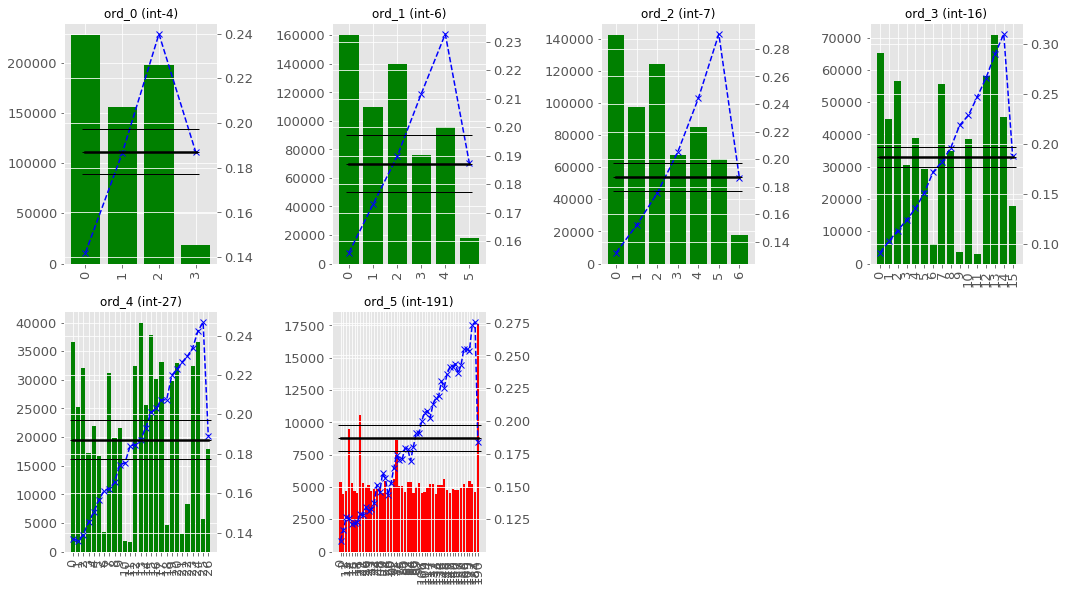

In [138]:
mutils.plot_multiple_categorical(oe.fit_transform(df.fillna("N_A")), ordinal_features, col_target="target", top_n=50)

In [ ]:
%%time
# Interactions for bin_3 & bin_4
df = train.copy()

target_cols = ["target"]
drop_cols = ["bin_3"]
all_train_cols = [col for col in df.columns if col not in target_cols+drop_cols+ordinal_features] 


# print(all_train_cols)
mfi = CustomMostFrequentImputer(ordinal_features)
oe = OrdinalEngineer(ordinal_features, transform_feat, normal_dict)
imputer = CustomNewCategoryImputer(all_train_cols)
scl = (pp.StandardScaler(copy=False), ordinal_features)
ohe = (pp.OneHotEncoder(categories="auto",dtype="uint8",handle_unknown="ignore"), all_train_cols)

pipe = make_pipeline(mfi, oe, imputer, make_column_transformer(ohe, scl), LogisticRegression(**lr_params))

bl3sc1, bl3cv1 = cross_val_print(pipe, df.drop(target_cols+drop_cols, axis=1), df["target"], cv=fold1, best_score=BASELINE["NAI1"])
bl3sc2, bl3cv2 = cross_val_print(pipe, df.drop(target_cols+drop_cols, axis=1), df["target"], cv=fold2, best_score=BASELINE["NAI2"])
bl3sc3, bl3cv3 = cross_val_print(pipe, df.drop(target_cols+drop_cols, axis=1), df["target"], cv=fold3, best_score=BASELINE["NAI3"])

print("Average: {} Baseline Avg: {} DIFF WRT Base: {}".format((bl3sc1+bl3sc2+bl3sc3)/3.0, (BASELINE["NAI1"]+BASELINE["NAI2"]+BASELINE["NAI3"])/3,((bl3sc1+bl3sc2+bl3sc3)/3.0 - (BASELINE["NAI1"]+BASELINE["NAI2"]+BASELINE["NAI3"])/3)))

↓CV1 valid score: 0.7837432 - Previous valid score: 0.7876527 - Train score: 0.798479 - Time 0:01:55.407666


Mean-ordered dictionary doesn't produce good results for any ordinal feature

In [140]:
%%time
# Interactions for bin_3 & bin_4
df = train.copy().fillna("N_A")

target_cols = ["target"]
drop_cols = ["bin_3"]

for curdinal in ordinal_features:
    print("Ordinal is : {}".format(curdinal))
    all_train_cols = [col for col in df.columns if col not in target_cols+drop_cols+[curdinal]] 

    # print(all_train_cols)
    oe = OrdinalEngineer([curdinal], transform_feat, normal_dict)
    
    imputer = CustomNewCategoryImputer(all_train_cols)
    
    scl = (pp.StandardScaler(copy=False), [curdinal])
    
    ohe = (pp.OneHotEncoder(categories="auto",dtype="uint8",handle_unknown="ignore"), all_train_cols)

    pipe = make_pipeline(oe, imputer, make_column_transformer(ohe, scl), LogisticRegression(**lr_params))

    bl3sc1, bl3cv1 = cross_val_print(pipe, df.drop(target_cols+drop_cols, axis=1), df["target"], cv=fold1, best_score=BASELINE["NAI1"])
# bl3sc2, bl3cv2 = cross_val_print(pipe, df.drop(target_cols+drop_cols, axis=1), df["target"], cv=fold2, best_score=BASELINE["NAI2"])
# bl3sc3, bl3cv3 = cross_val_print(pipe, df.drop(target_cols+drop_cols, axis=1), df["target"], cv=fold3, best_score=BASELINE["NAI3"])

# print("Average: {} Baseline Avg: {} DIFF WRT Base: {}".format((bl3sc1+bl3sc2+bl3sc3)/3.0, (BASELINE["NAI1"]+BASELINE["NAI2"]+BASELINE["NAI3"])/3,((bl3sc1+bl3sc2+bl3sc3)/3.0 - (BASELINE["NAI1"]+BASELINE["NAI2"]+BASELINE["NAI3"])/3)))

Ordinal is : ord_0
↓CV1 valid score: 0.7852167 - Previous valid score: 0.7876527 - Train score: 0.800658 - Time 0:01:52.899925
Ordinal is : ord_1
↓CV1 valid score: 0.7861608 - Previous valid score: 0.7876527 - Train score: 0.801485 - Time 0:01:51.077802
Ordinal is : ord_2
↓CV1 valid score: 0.7846173 - Previous valid score: 0.7876527 - Train score: 0.800063 - Time 0:01:52.767307
Ordinal is : ord_3
↓CV1 valid score: 0.7845116 - Previous valid score: 0.7876527 - Train score: 0.799962 - Time 0:01:54.577772
Ordinal is : ord_4
↓CV1 valid score: 0.7861547 - Previous valid score: 0.7876527 - Train score: 0.801418 - Time 0:01:53.020355
Ordinal is : ord_5
↓CV1 valid score: 0.7858649 - Previous valid score: 0.7876527 - Train score: 0.800628 - Time 0:01:49.715770
CPU times: user 6min 30s, sys: 30.2 s, total: 7min
Wall time: 11min 17s


In [141]:
%%time
# Most frequent encode the ordinal column, rest NA-col

target_cols = ["target"]
drop_cols = ["bin_3"]

for curdinal in ordinal_features:
    print("Ordinal is : {}".format(curdinal))
    all_train_cols = [col for col in df.columns if col not in target_cols+drop_cols+[curdinal]] 

    # print(all_train_cols)
    mfi = CustomMostFrequentImputer([curdinal])
    
    oe = OrdinalEngineer([curdinal], transform_feat, normal_dict)
    
    imputer = CustomNewCategoryImputer(all_train_cols)
    
    scl = (pp.StandardScaler(copy=False), [curdinal])
    
    ohe = (pp.OneHotEncoder(categories="auto",dtype="uint8",handle_unknown="ignore"), all_train_cols)

    pipe = make_pipeline(mfi, oe, imputer, make_column_transformer(ohe, scl), LogisticRegression(**lr_params))

    bl3sc1, bl3cv1 = cross_val_print(pipe, df.drop(target_cols+drop_cols, axis=1), df["target"], cv=fold1, best_score=BASELINE["NAI1"])
# bl3sc2, bl3cv2 = cross_val_print(pipe, df.drop(target_cols+drop_cols, axis=1), df["target"], cv=fold2, best_score=BASELINE["NAI2"])
# bl3sc3, bl3cv3 = cross_val_print(pipe, df.drop(target_cols+drop_cols, axis=1), df["target"], cv=fold3, best_score=BASELINE["NAI3"])

# print("Average: {} Baseline Avg: {} DIFF WRT Base: {}".format((bl3sc1+bl3sc2+bl3sc3)/3.0, (BASELINE["NAI1"]+BASELINE["NAI2"]+BASELINE["NAI3"])/3,((bl3sc1+bl3sc2+bl3sc3)/3.0 - (BASELINE["NAI1"]+BASELINE["NAI2"]+BASELINE["NAI3"])/3)))

Ordinal is : ord_0
↓CV1 valid score: 0.7852167 - Previous valid score: 0.7876527 - Train score: 0.800658 - Time 0:01:54.755829
Ordinal is : ord_1
↓CV1 valid score: 0.7861608 - Previous valid score: 0.7876527 - Train score: 0.801485 - Time 0:01:53.148291
Ordinal is : ord_2


KeyboardInterrupt: 